In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls -ls

In [0]:
cd /content/drive/nlp_all

In [0]:
# https://www.kaggle.com/c/word2vec-nlp-tutorial 의 데이터
# https://programmers.co.kr/learn/courses/21/lessons/946 참고
import pandas as pd

In [6]:
# 레이블인 sentiment가 있는 학습 데이터
train = pd.read_csv('labeledTrainData.tsv',header=0, delimiter='\t', quoting=3)

# 레이블이 없는 테스트 데이터
test = pd.read_csv('testData.tsv',header=0, delimiter='\t', quoting=3)

train.shape

(25000, 3)

In [7]:
train.tail()

,id,sentiment,review
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [8]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


# 텍스트 전처리

In [9]:
# review에 html코드가 섞여있어서 정제해줄 필요가 있음.
from bs4 import BeautifulSoup

#example1 = BeautifulSoup(train['review'][0], "html5lib")
example1 = BeautifulSoup(train['review'][0], "html.parser")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [10]:
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다. 
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [11]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

In [12]:
# 불용어 제거. 실제 의미를 찾는데 기여하지 않는 것.
## nltk에 영어 불용어가 미리 정의됨. 한국어는 없다고 함.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [13]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]
# 아까 437개였던 것이 219개로 줄어듬

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

# 형태소 분석

In [14]:
# 형태소 분석. 단어의 어간 분리.
# 포터 스태머의 사용 예 - 보수적
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))
print("--------------------------------------------------------------")
# 랭커스터 스태머의 사용 예 - 적극적
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
--------------------------------------------------------------
maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [15]:
from nltk.stem.snowball import SnowballStemmer
nltk.download('SnowballStemmer')
stemmer = SnowballStemmer('english')
print(words[:7])
print("---------------------- 형태소 분석 후 ----------------------")
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
print(words[:7])

[nltk_data] Error loading SnowballStemmer: Package 'SnowballStemmer'
[nltk_data]     not found in index
['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music']
---------------------- 형태소 분석 후 ----------------------
['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music']


# 음소표기법

In [16]:
# 문맥을 보고 명사로 쓰였는지 동사로 쓰였는지 등 파악
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]
# 처리 후 단어
words[:7]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
fly
fly


['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music']

# 문자열 처리

In [17]:
# 위에서 한거를 함수로 정리한 것일 뿐이다.
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는 게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )
  
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [18]:
from multiprocessing import Pool
import numpy as np

# 여기있는건 멀티프로세싱위한 부분이니 문자열 처리는 review_to_words만 보면 이해됨.

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))
  
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 131 ms, sys: 123 ms, total: 254 ms
Wall time: 54.7 s


In [19]:
clean_train_reviews.head()

0    stuff go moment mj start listen music watch od...
1    classic war world timothi hine entertain film ...
2    film start manag nichola bell give welcom inve...
3    must assum prais film greatest film opera ever...
4    superbl trashi wondrous unpretenti exploit hoo...
Name: review, dtype: object

In [20]:
%time clean_test_reviews = apply_by_multiprocessing(\
    test['review'], review_to_words, workers=4)    

CPU times: user 138 ms, sys: 119 ms, total: 258 ms
Wall time: 54.2 s


In [21]:
clean_test_reviews.head()

0    natur film main theme mortal nostalgia loss in...
1    movi disast within disast film full great acti...
2    movi kid saw tonight child love one point kid ...
3    afraid dark left impress sever differ screenpl...
4    accur depict small time mob life film new jers...
Name: review, dtype: object

파이썬 함수 선언에서 파라미터
#*args
함수의 입력값이 미정이거나 여러개를 받고 싶을 때 파라미터의 이름 앞에 *를 붙여준다.

args라는 이름이 아니어도 상관없다.


# **kwargs
keyword arguments의 약어이다.

모든 key=value 형태의 파라미터를 입력받았을 때, 입력값 전체를 kwargs라는 딕셔너리에 저장한다.

def func(*args, **kwargs):

        print(args)
        print(kwargs)

func(1, 2, 3, name='foo', age=3)

(1, 2, 3)

{'age': 3, 'name': 'foo'}

다만 func(1, 2, 3, name='foo', age=3, 4, 5) 와 같이 *args와 **kwargs 파라미터의 순서를 바꿔쓰면 오류가 나기때문에 func(1, 2, 3, 4, 5, name='foo', age=3) 다음과 같이 써야 오류가 나지 않는다. 

# 워드 클라우드

In [22]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

    100% |████████████████████████████████| 368kB 22.8MB/s 


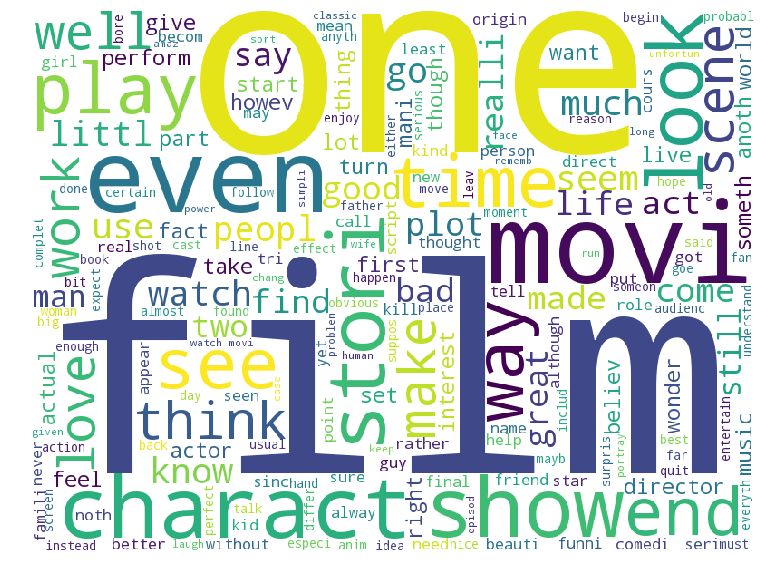

In [23]:
displayWordCloud(' '.join(clean_train_reviews))

# 한글폰트 사용하여 분포 그래프 그리기

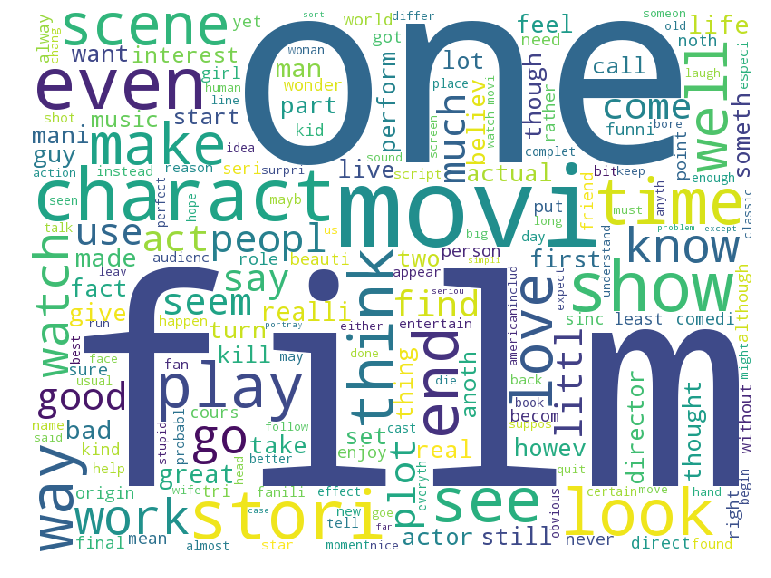

In [24]:
displayWordCloud(' '.join(clean_test_reviews))

In [0]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

In [26]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [27]:
# https://financedata.github.io/posts/matplotlib-hangul-for-ubuntu-linux.html
# https://stackoverflow.com/questions/51810908/custom-fonts-in-google-colaboratory-matplotlib-charts
# fc-cache 명령어가 안먹혀서 어찌어찌하니 되었다.
!apt-get install fonts-nanum*
!python -V

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 3 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-eco all 1.000-6 [14.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-extra all 20170925-1 [12.2 MB]
Get:4 http://archive.ubun

In [0]:
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /home/ubuntu/.cache/matplotlib/*

In [0]:
import matplotlib
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='NanumGothic')

리뷰 별 단어 평균값 : 119.52356
리뷰 별 단어 중간값 89.0
리뷰 별 고유 단어 평균값 : 94.05756
리뷰 별 고유 단어 중간값 74.0


Text(0.5,1,'리뷰 별 고유한 단어 수 분포')

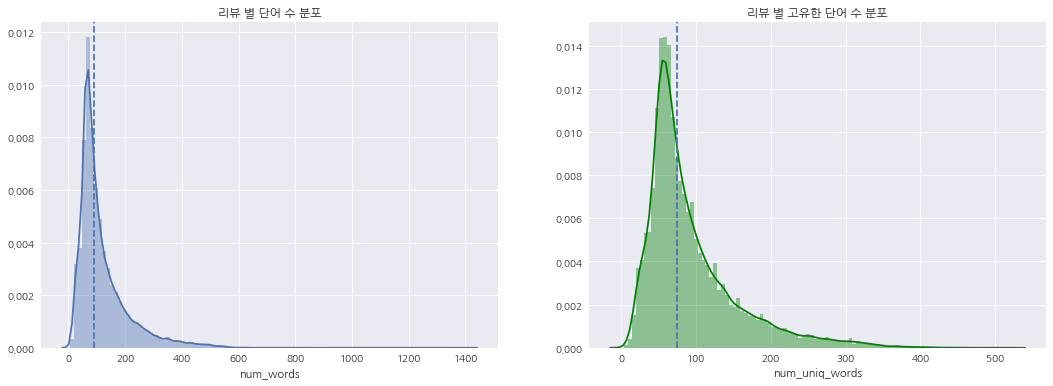

In [30]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰 별 단어 평균값 :', train['num_words'].mean())
print('리뷰 별 단어 중간값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰 별 단어 수 분포')

print('리뷰 별 고유 단어 평균값 :', train['num_uniq_words'].mean())
print('리뷰 별 고유 단어 중간값', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰 별 고유한 단어 수 분포')

# BOW

다음의 두 문장이 있다고 하자,

(1) John likes to watch movies. Mary likes movies too.

(2) John also likes to watch football games.


위 두 문장을 토큰화하여 가방에 담아주면 다음과 같다.

[    "John",    "likes",    "to",    "watch",    "movies",    "Mary",    "too",    "also",    "football",    "games"]

그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.

(1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]
(2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]

단어 가방을 n-gram을 사용해 bigram으로 담아주면 다음과 같다.

[    "John likes",    "likes to",    "to watch",    "watch movies",    "Mary likes",    "likes movies",    movies too",]

=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.


---



자세한 내용은 https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/

DictVectorizer: 각 단어의 수를 세어놓은 사전에서 BOW 벡터를 만든다.

v = DictVectorizer(sparse=False)
D = [{'A': 1, 'B': 2}, {'B': 3, 'C': 1}]
v.fit_transform(D)

array([[1., 2., 0.],
       [0., 3., 1.]])


---


CountVectorizer: 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다.

corpus = [
    'This is the first document.',    'This is the second second document.',    'And the third one.',   'Is this the first document?',    'The last document?',    ]

vect = CountVectorizer()

vect.fit(corpus)

vect.vocabulary_

{'this': 9, 'is': 3, 'the': 7, 'first': 2, 'document': 1, 'second': 6, 'and': 0, 'third': 8, 'one': 5, 'last': 4}

---

TfidfVectorizer: CountVectorizer와 비슷하지만 TF-IDF 방식으로 단어의 가중치를 조정한 BOW 벡터를 만든다.

TF-IDF인코딩은단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법이다.

구제적으로는 문서  d (document)와 단어  t  에 대해 다음과 같이 계산한다.

tf-idf(d,t)=tf(d,t) * idf(t)
 

tf(d,t) : term frequency. 특정한 단어의 빈도수

idf(t)  : inverse document frequency. 특정한 단어가 들어 있는 문서의 수에 반비례하는 수

idf(d,t)=log( n/(1+df(t)) )
 
n  : 전체 문서의 수

df(t) : 단어  t 를 가진 문서의 수

tfidv = TfidfVectorizer().fit(corpus)

tfidv.transform(corpus).toarray()

array([[0.        , 0.38947624, 0.55775063, 0.4629834 , 0.        ,        0.        , 0.        , 0.32941651, 0.        , 0.4629834 ],       [0.        , 0.24151532, 0.        , 0.28709733, 0.        ,        0.        , 0.85737594, 0.20427211, 0.        , 0.28709733],       [0.55666851, 0.        , 0.        , 0.        , 0.        ,        0.55666851, 0.        , 0.26525553, 0.55666851, 0.        ],       [0.        , 0.38947624, 0.55775063, 0.4629834 , 0.        ,        0.        , 0.        , 0.32941651, 0.        , 0.4629834 ],       [0.        , 0.45333103, 0.        , 0.        , 0.80465933,        0.        , 0.        , 0.38342448, 0.        , 0.        ]])

---

HashingVectorizer: 해시 함수(hash function)을 사용하여 적은 메모리와 빠른 속도로 BOW 벡터를 만든다.





In [31]:
# 사이킷런의 CountVectorizer를 통해 피처 생성
# 정규표현식을 사용해 토큰을 추출한다
# 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
# 의미 없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
# min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 크게 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선
# 참고 : https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
# TF-IDF도 사용할 수 있다는데 무슨소리인지는 모르겠다...
pipeline = Pipeline([
    ('vect', vectorizer),
])

# review_to_words 함수를 이용하여 전처리한 데이터를 BOW로 만듬.

%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

CPU times: user 37.9 s, sys: 874 ms, total: 38.8 s
Wall time: 38.8 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [34]:
# BOW의 칼럼 모임이라고 생각하면 될 듯. 여기서는 10개만 출력
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [35]:
# 벡터화된 피처를 확인해 봄
# 모든 문서의 BOW를 합산해서 출력하기
import numpy as np
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [36]:
# 각각의 bow가 어떤 모양일지 찍어봄. 특성이 이만개나 되어서 죄다 0인것처럼 보임.
pd.DataFrame(train_data_features[:100].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# RF로 예측해보기

In [0]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
# input : 그 문서의 BOW
# target : 그 문서의 sentiment
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1)
forest = forest.fit(train_data_features, train['sentiment'])

In [38]:
from sklearn.cross_validation import cross_val_score
np.mean(cross_val_score(forest, train_data_features, train['sentiment'], cv=10, scoring='roc_auc'))

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.927403168

In [39]:
# 위에서 정제해준 리뷰의 첫 번째 데이터를 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [0]:
# 테스트 데이터도 BOW만든다.
test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [41]:
# 벡터화된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
# 벡터화하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names() 였었다.
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [43]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [44]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [0]:
output.to_csv('tutorial_1_BOW_model.csv', index=False, quoting=3)
# test셋의 실제 결과는 Kaggle 사이트만 알고 있다. 점수 확인하고 싶으면 업로드해야함.

In [46]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

-90


1    12545
0    12455
Name: sentiment, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


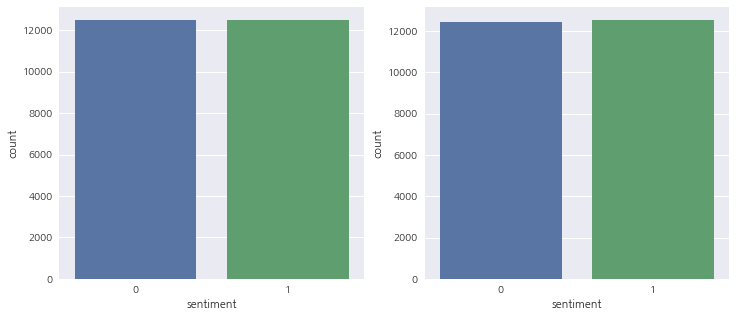

In [47]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

# Word2Vec

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/

https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/11/embedding/

원핫인코딩 또는 BOW에서는 벡터사이즈가 매우 커서 sparse. Neural Net성능이 안좋아짐.

단어를 트레이닝 시킬때 주위 단어를 label로 매치하여 최적화. 개념 간 유사성을 볼 수 있다.

# CBOW와 Skip-Gram

CBOW(continuous bag-of-words)는 전체 텍스트로 하나의 단어를 예측하기 때문에 작은 데이터 세트일 수록 유리하다.

1) _ _가 맛있다. 
2) _ _를 타는 것이 재미있다. 
3) 평소보다 두 _ _로 많이 먹어서 _ _가 아프다.

Skip-Gram은 타겟 단어들로부터 원본 단어를 역으로 예측하는 것이다. CBOW와는 반대로 컨텍스트-타겟 쌍을 새로운 발견으로 처리하고 큰 규모의 데이터셋을 가질 때 유리하다.

1) *배*가 맛있다. 
2) *배*를 타는 것이 재미있다. 
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.



In [0]:
unlabeled_train = pd.read_csv('unlabeledTrainData.tsv',header=0, delimiter='\t', quoting=3)

In [49]:
unlabeled_train.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [0]:
'''# 구글드라이브의 모듈 임포드하기!!
import sys
#sys.path.append("/content/drive")
print(sys.path)'''
# 위에서 한 전처리 모음.
from KaggleWord2VecUtility import KaggleWord2VecUtility

In [51]:
KaggleWord2VecUtility.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [54]:
# KaggleWord2VecUtility 코드 중에 review_to_sentences는 뭔지 궁금해서 뜯어봄.
# strip은 있으나 없으나 똑같긴한데 코드상에 있으니 일단 냅둠.
# review_to_sentences내의 토크나이저는 문장단위로 잘라주는 녀석.
nltk.download('punkt')
print(train["review"][0].strip())
print("")
tt = nltk.data.load('tokenizers/punkt/english.pickle')
print(tt.tokenize(train["review"][0].strip()))
print(np.array(tt.tokenize(train["review"][0].strip())).shape)
print("")
# review_to_wordlist는 걍 통째로 전처리해주는 녀석이고(윗 부분의 review_to_word랑 같음)
print(KaggleWord2VecUtility.review_to_wordlist(train['review'][0]))
print(np.array(KaggleWord2VecUtility.review_to_wordlist(train['review'][0])).shape)
# review_to_sentences는 문장별로 전처리해서 보여준다.
# word2vec이 문장단위로 처리를 해서 그런듯???
print("")
print(KaggleWord2VecUtility.review_to_sentences(train['review'][0]))
print(np.array(KaggleWord2VecUtility.review_to_sentences(train['review'][0])).shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it fo

In [55]:
sentences = []
nltk.download('punkt')
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [56]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packa

In [57]:
# 이전의 예제와 다르게 모듈에서는 stopword 설정 안함.
# 문맥의 의미를 파악하는 것이기 때문에 stopword도 포함시키는 것이 더 좋지않을까 했다고함.
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [58]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

In [59]:
np.array(sentences)

array([list(['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'start', 'listen', 'to', 'his', 'music', 'watch', 'the', 'odd', 'documentari', 'here', 'and', 'there', 'watch', 'the', 'wiz', 'and', 'watch', 'moonwalk', 'again']),
       list(['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'realli', 'cool', 'in', 'the', 'eighti', 'just', 'to', 'mayb', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilti', 'or', 'innoc']),
       list(['moonwalk', 'is', 'part', 'biographi', 'part', 'featur', 'film', 'which', 'i', 'rememb', 'go', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'origin', 'releas']),
       ...,
       list(['not', 'much', 'happenen', 'except', 'for', 'some', 'funni', 'scene', 'where', 'teen', 'touch', 'some', 'radioact', 'goo', 'on', 'the', 'mummi', 'and', 'start', 'to', 'get', 'fungus', 'grow', 'all', 'over', 'them']),
       list(['the', 'pa

#Word2Vec 모델 학습

아키텍처 : 아키텍처 옵션은 skip-gram (default) 또는 CBOW 모델이다. skip-gram (default)은 느리지만 더 나은 결과를 낸다.

학습 알고리즘 : Hierarchical softmax (default) 또는 negative 샘플링. 여기에서는 기본값이 잘 동작한다.

빈번하게 등장하는 단어에 대한 다운 샘플링 : Google 문서는 .00001에서 .001 사이의 값을 권장한다. 여기에서는 0.001에 가까운 값이 최종 모델의 정확도를 높이는 것으로 보여진다.

단어 벡터 차원 : 많은 feature를 사용한다고 항상 좋은 것은 아니지만 대체적으로 좀 더 나은 모델이 된다. 합리적인 값은 수십에서 수백 개가 될 수 있고 여기에서는 300으로 지정했다.

컨텍스트 / 창 크기 : 학습 알고리즘이 고려해야 하는 컨텍스트의 단어 수는 얼마나 될까? hierarchical softmax 를 위해 좀 더 큰 수가 좋지만 10 정도가 적당하다.

Worker threads : 실행할 병렬 프로세스의 수로 컴퓨터마다 다르지만 대부분의 시스템에서 4에서 6 사이의 값을 사용하다.

최소 단어 수 : 어휘의 크기를 의미 있는 단어로 제한하는 데 도움이 된다. 모든 문서에서 여러 번 발생하지 않는 단어는 무시된다. 10에서 100 사이가 적당하며, 이 경진대회의 데이터는 각 영화가 30개씩의 리뷰가 있기 때문에 개별 영화 제목에 너무 많은 중요성이 붙는 것을 피하고자 최소 단어 수를 40으로 설정한다. 그 결과 전체 어휘 크기는 약 15,000단어가 된다. 높은 값은 제한 된 실행시간에 도움이 된다.

In [0]:
# log파일
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [61]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 초기화 및 모델 학습
!pip install gensim
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

    100% |████████████████████████████████| 23.6MB 1.7MB/s 
    100% |████████████████████████████████| 1.4MB 14.8MB/s 
    100% |████████████████████████████████| 133kB 26.8MB/s 
    100% |████████████████████████████████| 4.7MB 6.6MB/s 
    100% |████████████████████████████████| 61kB 22.4MB/s 
    100% |████████████████████████████████| 552kB 24.5MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


2018-11-04 12:14:15,378 : INFO : 'pattern' package not found; tag filters are not available for English
2018-11-04 12:14:15,384 : INFO : collecting all words and their counts
2018-11-04 12:14:15,385 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-04 12:14:15,457 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2018-11-04 12:14:15,526 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2018-11-04 12:14:15,595 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2018-11-04 12:14:15,668 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2018-11-04 12:14:15,738 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2018-11-04 12:14:15,810 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2018-11-04 12:14:15,881 : INFO : PROGRESS: at senten

In [62]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

2018-11-04 12:17:31,560 : INFO : precomputing L2-norms of word weight vectors
2018-11-04 12:17:31,676 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-11-04 12:17:31,678 : INFO : not storing attribute vectors_norm
2018-11-04 12:17:31,680 : INFO : not storing attribute cum_table
2018-11-04 12:17:59,831 : INFO : saved 300features_40minwords_10text


In [63]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'kitchen'

In [64]:
model.wv.doesnt_match("france england germany berlin".split())

2018-11-04 12:18:02,771 : WARNING : vectors for words {'france', 'germany'} are not present in the model, ignoring these words
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'berlin'

In [65]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.6310314536094666),
 ('millionair', 0.5116128921508789),
 ('businessman', 0.5082247853279114),
 ('lad', 0.5041278004646301),
 ('ladi', 0.4811864495277405),
 ('farmer', 0.470051109790802),
 ('men', 0.46342170238494873),
 ('loner', 0.45808714628219604),
 ('thief', 0.4498278498649597),
 ('billionair', 0.4454435110092163)]

In [66]:
model.wv.most_similar("queen")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('princess', 0.5867595076560974),
 ('victoria', 0.5795361399650574),
 ('maid', 0.5711259841918945),
 ('duchess', 0.5492937564849854),
 ('latifah', 0.5405652523040771),
 ('maria', 0.5371453762054443),
 ('mistress', 0.5367529988288879),
 ('anita', 0.5361770391464233),
 ('dame', 0.5360792279243469),
 ('bride', 0.5350773334503174)]

In [67]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2018-11-04 12:18:09,361 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-11-04 12:18:09,677 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-11-04 12:18:09,678 : INFO : setting ignored attribute vectors_norm to None
2018-11-04 12:18:09,683 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2018-11-04 12:18:09,684 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2018-11-04 12:18:09,686 : INFO : setting ignored attribute cum_table to None
2018-11-04 12:18:09,689 : INFO : loaded 300features_40minwords_10text
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


11986
[ 0.04905214 -0.05785679  0.02793033 -0.03441549 -0.03519334  0.09495704
 -0.0147968   0.03553797  0.02599509 -0.03328635]


In [68]:
# 이 X가 word2vec인듯
np.array(X).shape

(11986, 300)

In [69]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

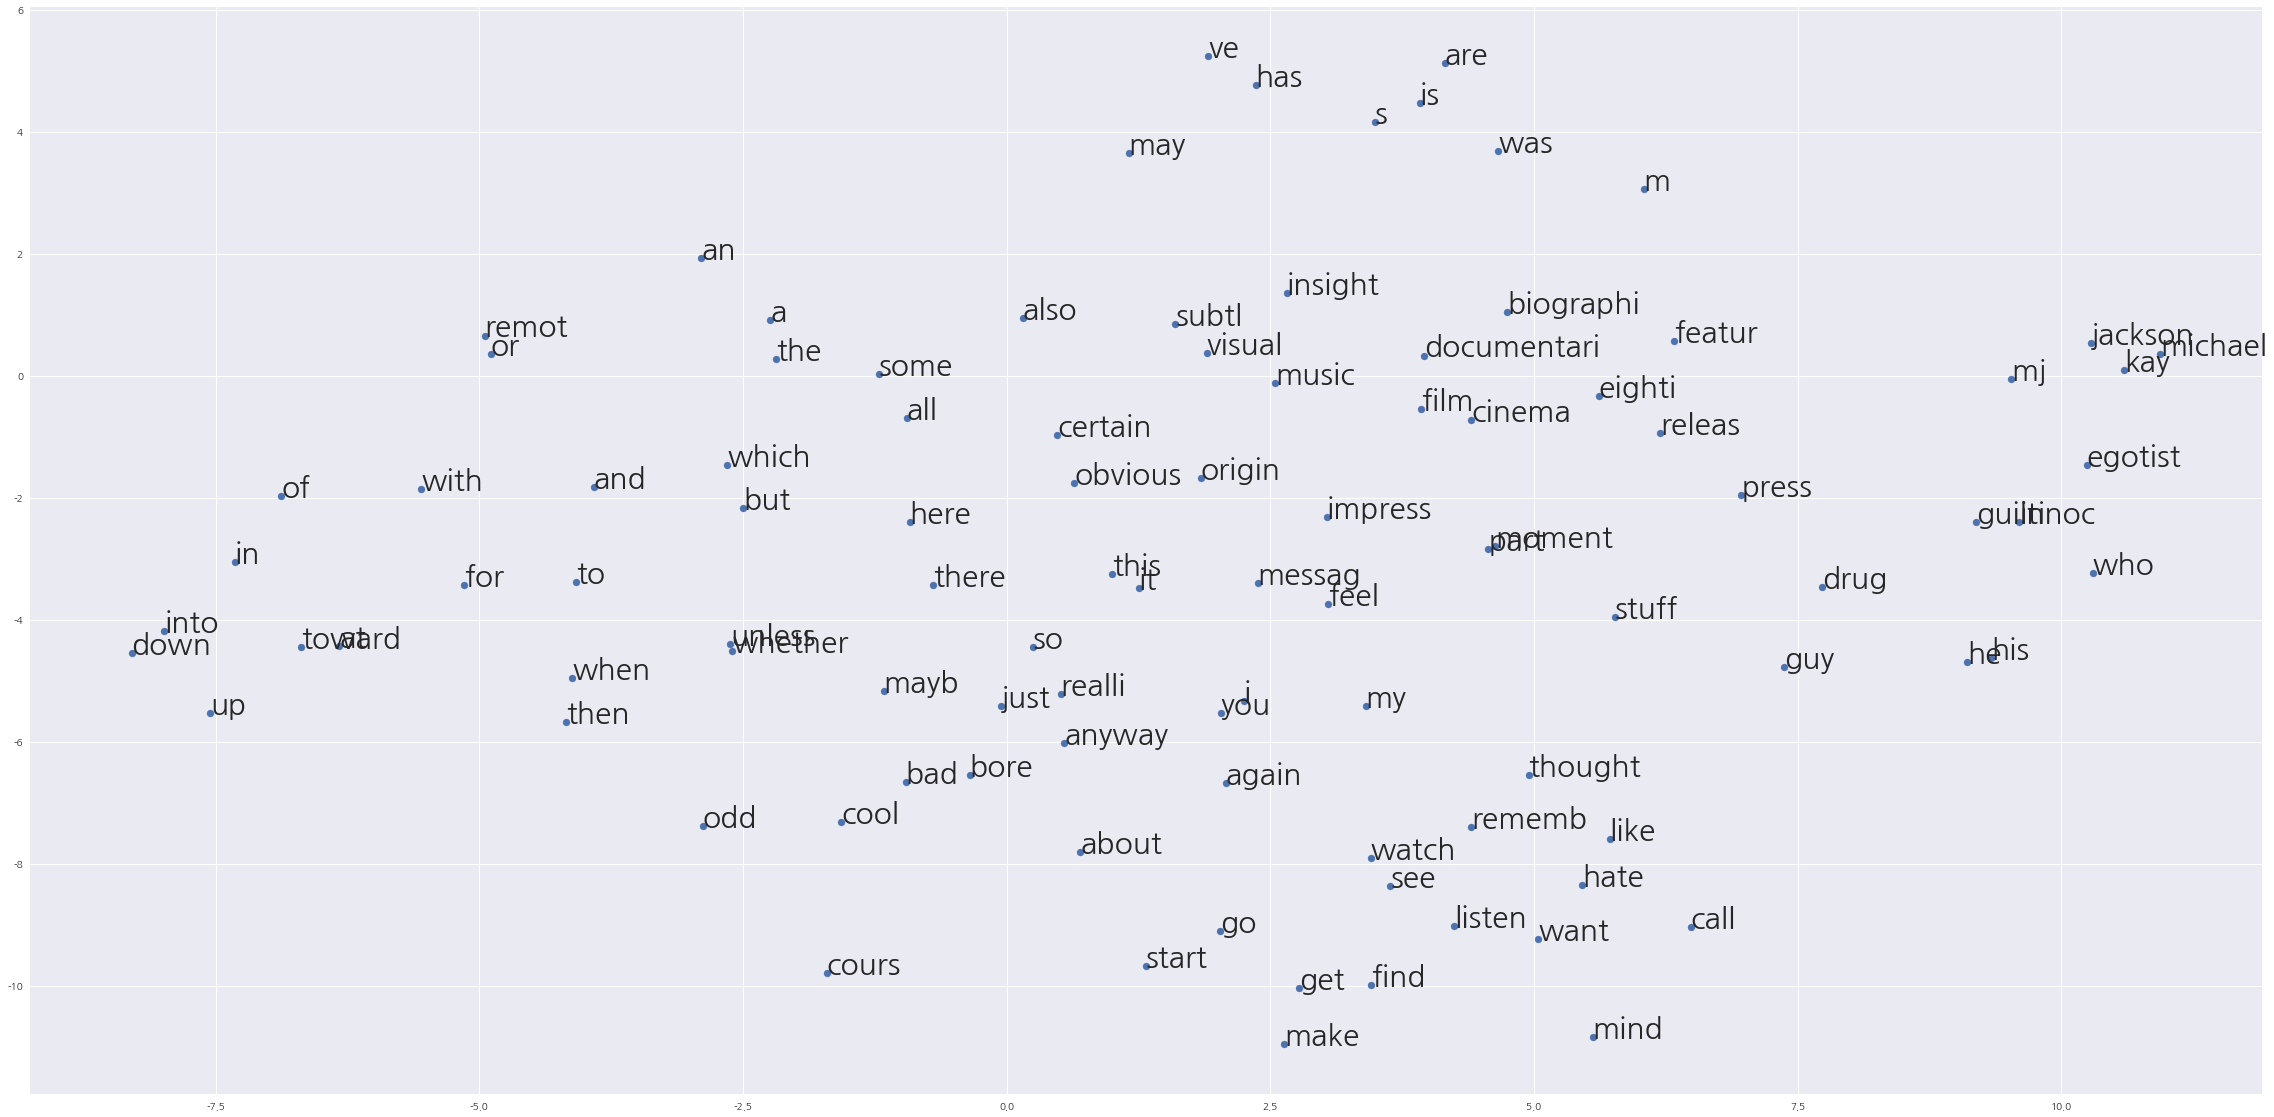

In [70]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [0]:
def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어 명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어 수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec
  
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.

    # 카운터를 초기화한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")

    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(reviews["review"],
             KaggleWord2VecUtility.review_to_wordlist,workers=4)
   
    return clean_reviews

In [72]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features ) 

Review 0 of 25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 3s, sys: 1.64 s, total: 1min 4s
Wall time: 2min 20s


In [73]:
%time testDataVecs = getAvgFeatureVecs(\
    getCleanReviews(test), model, num_features ) 

Review 0 of 25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 2s, sys: 1.93 s, total: 1min 4s
Wall time: 2min 19s


In [0]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [75]:
print(np.array(trainDataVecs).shape)
print(np.array(train).shape)

(25000, 300)
(25000, 5)


In [76]:
# input : traindata중 'review'에 해당하는 녀석들.(문장단위x)
# target : traindata의 'sentiment'
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 5s, sys: 54.6 ms, total: 1min 5s
Wall time: 33.3 s


In [77]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

CPU times: user 9min 41s, sys: 522 ms, total: 9min 41s
Wall time: 4min 55s


0.9024747200000001

In [0]:
result = forest.predict( testDataVecs )
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), 
              index=False, quoting=3 )

In [79]:
output_sentiment = output['sentiment'].value_counts()
# 0으로 분류한 개수와 1로 분류한 개수의 차이
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

130


0    12565
1    12435
Name: sentiment, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


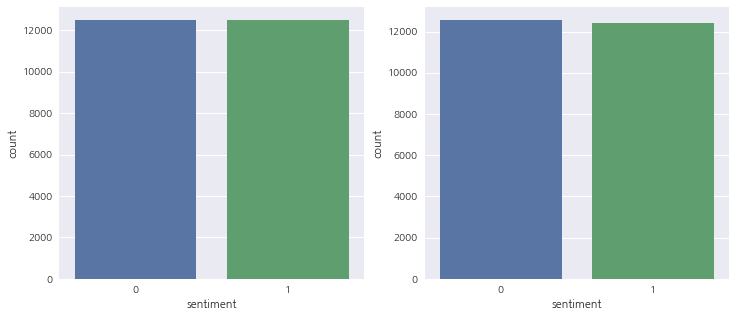

In [80]:
# 좌측은 trainset, 우측은 testset의 label당 개수
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [82]:
# kmeans 클러스터링하고 RF이용하여 리뷰가 추천인지 아닌지 구별해보자.
from sklearn.cluster import KMeans
from gensim.models.word2vec import Word2Vec

from nltk.corpus import stopwords
import nltk.data
model = Word2Vec.load('300features_40minwords_10text')
model

2018-11-04 12:39:55,267 : INFO : loading Word2Vec object from 300features_40minwords_10text
2018-11-04 12:39:56,327 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-11-04 12:39:56,329 : INFO : setting ignored attribute vectors_norm to None
2018-11-04 12:39:56,330 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2018-11-04 12:39:56,331 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2018-11-04 12:39:56,334 : INFO : setting ignored attribute cum_table to None
2018-11-04 12:39:56,336 : INFO : loaded 300features_40minwords_10text


In [83]:
# 숫자로 단어를 표현
# Word2Vec 모델은 어휘의 각 단어에 대한 feature 벡터로 구성되며
# 'syn0'이라는 넘파이 배열로 저장된다.
# syn0의 행 수는 모델 어휘의 단어 수
# 컬럼 수는 위에서 설정한 피처 벡터의 크기
type(model.wv.syn0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [84]:
model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(11986, 300)

In [86]:
import time
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5이나 평균 5단어로 설정한다.
word_vectors = model.wv.syn0 # 어휘의 feature vector
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)

# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Time taken for K Means clustering:  349.3136866092682 seconds.


In [87]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫 번째 클러스터의 처음 10개만 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))

    # 클러스터 번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['port', 'bunker', 'ch', 'headquart', 'embassi', 'detent', 'oxford', 'cadet']

Cluster 1
['shenanigan', 'allegi', 'helper']

Cluster 2
['henri', 'bridget']

Cluster 3
['un']

Cluster 4
['fridg', 'refriger']

Cluster 5
['hideous', 'grotesqu', 'nauseat', 'ghast', 'bloodless']

Cluster 6
['distinguish', 'differenti']

Cluster 7
['dame', 'muse', 'nina', 'cum', 'rosario', 'erin', 'lulu', 'beal', 'hairdress', 'rossellini', 'marius', 'charmer', 'anand', 'foch']

Cluster 8
['underworld', 'warlord', 'smuggler', 'hussein']

Cluster 9
['daniel', 'stephen', 'arthur', 'ian', 'heston', 'everett', 'rupert', 'brett', 'sloan', 'nigel', 'tucci', 'swayz', 'rubin', 'mcshane', 'lom']


In [0]:
"""
판다스로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1), 
QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와 
clean_test_reviews 로 텍스트를 정제한다.
"""
train = pd.read_csv('labeledTrainData.tsv', 
                    header=0, delimiter="\t", quoting=3)
test = pd.read_csv('testData.tsv', 
                   header=0, delimiter="\t", quoting=3)

In [0]:
from KaggleWord2VecUtility import KaggleWord2VecUtility
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [0]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [93]:
# bags of centroids 생성
# 속도를 위해 centroid 학습 세트 bag을 미리 할당한다.
train_centroids = np.zeros((train["review"].size, num_clusters), \
    dtype="float32" )
train_centroids[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):

    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1

    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )

    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당하는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1

    # bag of centroids를 반환한다.
    return bag_of_centroids
# 학습 리뷰를 bags of centroids로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

In [95]:
# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

Fitting a random forest to labeled training data...
CPU times: user 37.1 s, sys: 12.8 ms, total: 37.1 s
Wall time: 37.1 s


In [96]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_centroids, train['sentiment'], cv=10,\
    scoring='roc_auc'))

CPU times: user 5min 26s, sys: 213 ms, total: 5min 26s
Wall time: 5min 26s


In [97]:
%time result = forest.predict(test_centroids)

CPU times: user 1.65 s, sys: 2.93 ms, total: 1.65 s
Wall time: 1.66 s


In [98]:
score

0.9135223680000001

In [0]:
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


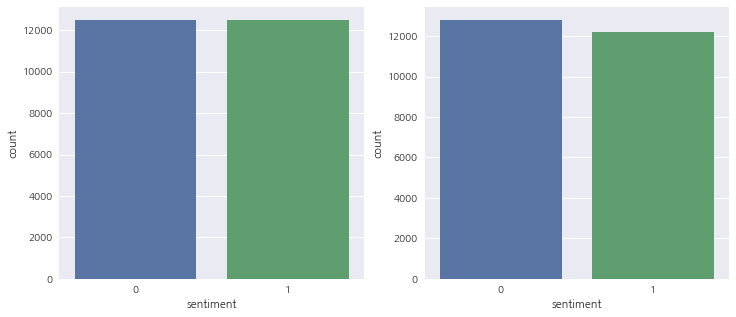

In [100]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [101]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

604


0    12802
1    12198
Name: sentiment, dtype: int64

# TF-IDF로 단어 벡터화하기

In [102]:
# 긍정과 부정 리뷰가 어떻게 들어있는지 카운트 해본다.
# 긍정과 부정리뷰가 각각 동일하게 12,500개씩 들어있다.
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [0]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def review_to_words( raw_review ):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    review_text = wordnet_lemmatizer.lemmatize(review_text)
    return review_text 

In [104]:
# 학습데이터를 전처리 한다.
%time train['review_clean'] = KaggleWord2VecUtility.apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

CPU times: user 109 ms, sys: 530 ms, total: 639 ms
Wall time: 4.22 s


In [105]:
%time test['review_clean'] = KaggleWord2VecUtility.apply_by_multiprocessing(\
    test['review'], review_to_words, workers=4)

CPU times: user 115 ms, sys: 527 ms, total: 642 ms
Wall time: 4.86 s


In [106]:
# 전처리한 학습 데이터 10개만을 불러와서 본다.
train['review_clean'][:10]

0    "With all this stuff going down at the moment ...
1    "\"The Classic War of the Worlds\" by Timothy ...
2    "The film starts with a manager (Nicholas Bell...
3    "It must be assumed that those who praised thi...
4    "Superbly trashy and wondrously unpretentious ...
5    "I dont know why people think this is such a b...
6    "This movie could have been very good, but com...
7    "I watched this video at a friend's house. I'm...
8    "A friend of mine bought this film for £1, and...
9    "This movie is full of references. Like \"Mad ...
Name: review_clean, dtype: object

In [107]:
# 전처리한 테스트 데이터 10개만을 불러와서 본다.
test['review_clean'][:10]

0    "Naturally in a film who's main themes are of ...
1    "This movie is a disaster within a disaster fi...
2    "All in all, this is a movie for kids. We saw ...
3    "Afraid of the Dark left me with the impressio...
4    "A very accurate depiction of small time mob l...
5    "...as valuable as King Tut's tomb! (OK, maybe...
6    "This has to be one of the biggest misfires ev...
7    "This is one of those movies I watched, and wo...
8    "The worst movie i've seen in years (and i've ...
9    "Five medical students (Kevin Bacon, David Lab...
Name: review_clean, dtype: object

In [0]:
# X_train과 X_test에 리뷰 데이터를 담아주고 이 데이터를 TF-IDF를 통해 임베딩(벡터화)해본다. 
X_train = train['review_clean']
X_test = test['review_clean']

In [111]:
'''
IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만,
원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.
역문서 빈도(IDF)는 한 단어가 문서 집합 전체에서 얼마나 공통적으로 나타나는지를 나타내는 값이다.
전체 문서의 수를 해당 단어를 포함한 문서의 수로 나눈 뒤 로그를 취하여 얻을 수 있다.
'''
nltk.download('words')
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import words

vectorizer = CountVectorizer(analyzer = 'word', 
                             lowercase = True,
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3),
                             vocabulary = set(words.words()), # nltk의 words를 사용하거나 문서 자체의 사전을 만들거나 선택한다. 
                             max_features = 90000
                            )
vectorizer

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=90000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'cornutine', 'aminodiphenyl', 'trustee', 'microtia', 'claymore', 'polygenesis', 'reundulation', 'nonsister', 'sludger', 'Mithraitic', 'poststernal', 'protophyll', 'flaxwench', 'hypsometrist', 'pillaret', 'uncountenanced', 'monospermic', 'grossularia', 'recoverless', 'stachys', 'underorse...toxime', 'gynaecea', 'unvulgarly', 'weedling', 'maharao', 'pyjamaed', 'paludicole', 'masterfulness'})

In [112]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer(smooth_idf = False)),
])  
pipeline

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=90000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
       ...('tfidf', TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True))])

In [113]:
%time X_train_tfidf_vector = pipeline.fit_transform(X_train)

CPU times: user 8.43 s, sys: 49.3 ms, total: 8.48 s
Wall time: 8.49 s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [114]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

235892


['A',
 'Aani',
 'Aaron',
 'Aaronic',
 'Aaronical',
 'Aaronite',
 'Aaronitic',
 'Aaru',
 'Ab',
 'Ababdeh']

In [115]:
%time X_test_tfidf_vector = pipeline.fit_transform(X_test)

CPU times: user 8.31 s, sys: 15.3 ms, total: 8.32 s
Wall time: 8.33 s


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [116]:
dist = np.sum(X_train_tfidf_vector, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns=vocab)

[[0. 0. 0. ... 0. 0. 0.]] A


,A,Aani,Aaron,Aaronic,Aaronical,Aaronite,Aaronitic,Aaru,Ab,Ababdeh,...,zymotechnical,zymotechnics,zymotechny,zymotic,zymotically,zymotize,zymotoxic,zymurgy,zythem,zythum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [118]:
%time forest = forest.fit(X_train_tfidf_vector, train['sentiment'])

CPU times: user 3min 39s, sys: 182 ms, total: 3min 39s
Wall time: 1min 51s


In [119]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=2018)

%time score = np.mean(cross_val_score(\
    forest, X_train_tfidf_vector, \
    train['sentiment'], cv=k_fold, scoring='roc_auc', n_jobs=-1))

CPU times: user 2.07 s, sys: 374 ms, total: 2.45 s
Wall time: 7min 45s


In [120]:
'{:,.5f}'.format(score)

'0.92051'

In [121]:
%time result = forest.predict(X_test_tfidf_vector)

CPU times: user 4.13 s, sys: 40.9 ms, total: 4.17 s
Wall time: 2.24 s


In [122]:
result[:10]

array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

In [123]:
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",0
4,"""12128_7""",1


In [124]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

-378


1    12689
0    12311
Name: sentiment, dtype: int64

In [0]:
output.to_csv('tutorial_4_tfidf_{0:.5f}.csv'.format(score), index=False, quoting=3)